# Interpreting hyperspectral tabluar data with SHAP: HYPERVIEW Challenge


This notebook demonstrates the usability of the explanations with [SHapley Additive exPlanations](https://papers.nips.cc/paper_files/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html) to interpret the predictions of a hyperspectral image regression model. The dataset used in this notebook is from the [HYPERVIEW Challenge](https://platform.ai4eo.eu/seeing-beyond-the-visible-permanent) organized by KP Labs and European Space Agency (ESA). The goal of the challenge is to predict `4` soil parameters based on the airborne hyperspectral images.

The analysed model is Random Forest, which is the top-performing model from the HYPERVIEW Challenge. It works on the carefully preprocessed dataframe, created from  the input hyperspectral images. In short, the preprocessing pipeline applies several transformations to the reflectance values, such as averaging the reflectance values, applying the Fast Fourier Transformation or discrete wavelet transform. The description of the preprocessing steps can be found [here](https://github.com/ridvansalihkuzu/hyperview_eagleeyes/blob/master/challenge_submission_eagleeyes/hyperview-main-submission_eagleeyes.ipynb).

**Note**: Before running this notebook, make sure to install the required libraries used in the notebook. 
Except for the `meteors` package, you will probably need to install package used for preprocessing of the HYPERVIEW dataset.


Missing dependencies:
```
pip install PyWavelets
```

## Table of Contents


## Data loading


Here, to make this tutorial executable, we skip calculation of the explanations for the whole HYPERVIEW dataset. Analysis of this kind of explanations can be found in the paper published by us: [Red Teaming Models for Hyperspectral Image Analysis Using Explainable AI](https://arxiv.org/abs/2403.08017).



To analyze the EagleEyes model, we firstly need to apply the preprocessing, as described [here](https://huggingface.co/KPLabs/HYPERVIEW-RandomForest).



In [1]:
import meteors as mt
import matplotlib.pyplot as plt
import os
import joblib
import numpy as np

In [2]:
from typing import List
from eagleeyes import load_and_preprocess, download, get_raw_data

samples_list, y_train = get_raw_data()

# ensure that correct number of samples are loaded
assert len(samples_list) == 10, len(y_train) == 10

# possibly add some visualization here



Now let's apply the preprocessing that was the key to winning the HYPERVIEW Challenge!

In [3]:
features: List[str] = ["fft", "dwt", "gradient", "mean"]

X_train = load_and_preprocess(samples_list, features)

print("X_train shape:", X_train.shape)

100%|██████████| 10/10 [00:00<00:00, 24.56it/s]

X_train shape: (10, 1200)


The preprocessed dataframe has in total 1200 features. This number comes from 8 types of preprocessing and 150 different reflectance values measured. To simplify the model's input, the original preprocessing pipeline have aggregated the reflectance values across the whole image.

In [4]:
with open("data/wavelenghts.txt", "r") as f:
    wavelengths = f.readline()
wavelengths = [float(wave.strip()) for wave in wavelengths.split(",")]

print("Number of different bands measured:", len(wavelengths))

Number of different bands measured: 150



## Model preparation
Now, let's load the model from the Hugging Face Hub. Our model of interet is the EagleEyes model, which is a Random Forest model trained on the HYPERVIEW dataset. It was trained on the preprocessed data, using `scikit-learn==1.3.1`, thus the possible version mismatch between the model and the library versions in the code below.

In [5]:
download_root = os.path.expanduser("~/.cache/eagleeyes")
num_classes = 4

In [6]:
rf_checkpoint_path = download(
    "https://huggingface.co/KPLabs/HYPERVIEW-RandomForest/resolve/main/RF_model_150_bands.joblib",
    download_root,
    error_checksum=False,
)

In [7]:
model = joblib.load(rf_checkpoint_path)

Now, the model should have been sucessfully loaded. Let us run it on a sample data and review the predictions.

In [8]:
model.predict(X_train)[0]

array([ 57.471 , 208.45  , 157.1   ,   6.8339])

It returns 4 values, each of them corresponds to measured soil parameter. The parameters are:
- Phosphorus
- Potassium
- Magnesium
- pH

In [9]:
np.mean((model.predict(X_train) - y_train) ** 2, axis=0)  # third observation gives a lot of error

P      520.337014
K     1794.494350
Mg     475.594643
pH       0.050696
dtype: float64

## SHAP Explanations 

[**SHapley Additive exPlanations (SHAP)**](https://papers.nips.cc/paper_files/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html) is a very popular method for explaining predictive, especially regression, models.

Similarily to LIME, also covered in [one of our tutorials](https://xai4space.github.io/meteors/latest/tutorials/lime/), SHAP approximates model's local behaviour, by calculating the change in its prediction if a given feature is removed.

This simple idea is denoted as a **Shapley value** **\varphi_i(x)**, which is a change of prediction when variable *i* is added to the data. In fact, the intuition is wrapped in an elegant formula:




$$
\varphi_i(x) = \sum_{S \subseteq P \setminus \{i\}} \frac{|S|! \, (p - |S| - 1)!}{p!} \left(v_{S \cup \{i\}}(x) - v_S(x)\right),
$$
where: 
$\varphi_i(x)$ is the **Shapely value**, $S$ corresponds to a selected coalitions of features, $P$ represents all features and $v_{S}(x)$ corresponds to the model's prediction if we select only features from coalition $S$. 

---

To initialize the `HyperSHAP` object, we need to wrap our predictive model into the `mt.models.ExplainableModel` class. In this way, we can pass some additional metadata to the explainability methods implemented in the package. Our problem type is `regression` as we predict numerical soil parameters.

Then, we need to initialize the explainer itself - using the `mt.shap.HyperSHAP` class. It requires the wrapped model to be passed as a parameter, along with a *masker*, which is a dataframe on which the model was trained (here it is not needed for the scope of this tutorial) and additional parameters. Feature names are used for the visualization and explainer type is a field that defines which algorithm the package will use to calculate the shapley values. The available options are: `exact`, `tree`, `kernel`, `linear`, which correponds to the model type. Here we will use the `tree` explainer, since our model is also tree-based.

In the end, we need to create an explanation using one method - `explain`.

In [10]:
explainable_model = mt.models.ExplainableModel(model, problem_type="regression")

explainer = mt.shap.HyperSHAP(explainable_model, masker=None, feature_names=X_train.columns, explainer_type="tree")

explanation = explainer.explain(X_train)

We have sucessfully created the explanations! Now let us  visualize them using different methods and investigate what those mean!

Meteors package supports several plots, which now be described in detail. The majority of them are sourced from the `shap` package, with an exception of the `wavelengths_bar` plot, which is a custom plot implemented in the `meteors` package. The list of available plots is as follows. In the meantime, we are working on adding more plots to the package, so stay tuned for the updates!


### Force plot

The force plot is a visualization of the SHAP values for a single prediction. It shows how each feature contributes to the final prediction, by *dragging* the final prediction with feature *forces*. In this way, we can see which features are pushing the prediction higher or lower, and how much they contribute to the final prediction. 

In the plot below, you can see that the prediction for Potassium is much higher than the baseline value for the model (the expected value of the model prediction). One of the features that contributes the most to this change is the 2nd derivative of average reflectance, measured at wavelength `657.07 nm`.

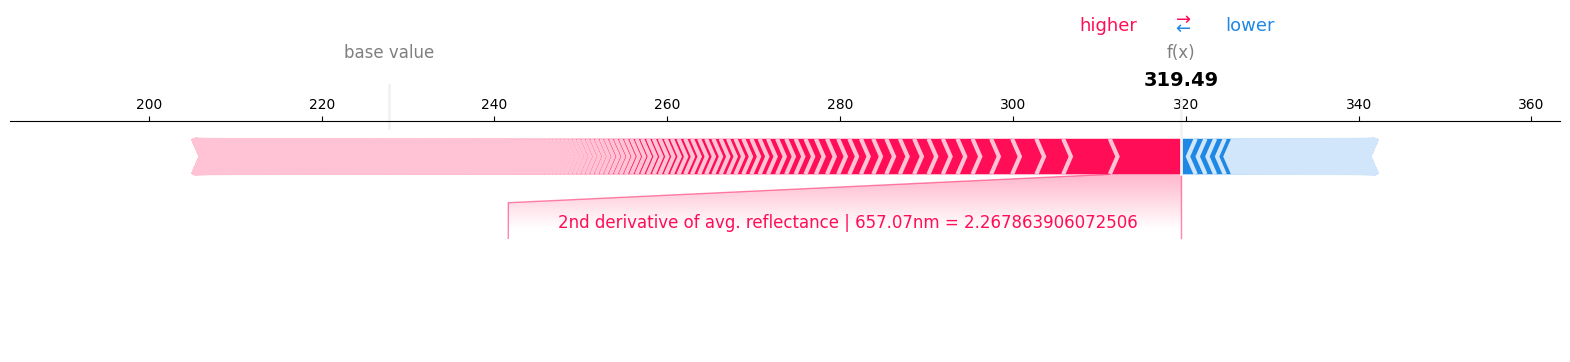

In [35]:
from meteors.visualize import force


force(explainer, explanation, target=1, observation_index=3, use_pyplot=True)

### Waterfall plot

The waterfall plot is another visualization that shows the SHAP values for a single prediction. It shows how each feature contributes to the final prediction, by *stacking* the SHAP values on top of each other. Using a waterfall plot, we can easily identify the features with the highest importance and how they contribute to the final prediction.

Here, similarily as in the force plot, we can see that the transformation of band `657.07 nm` is the most important for the prediction of Potassium

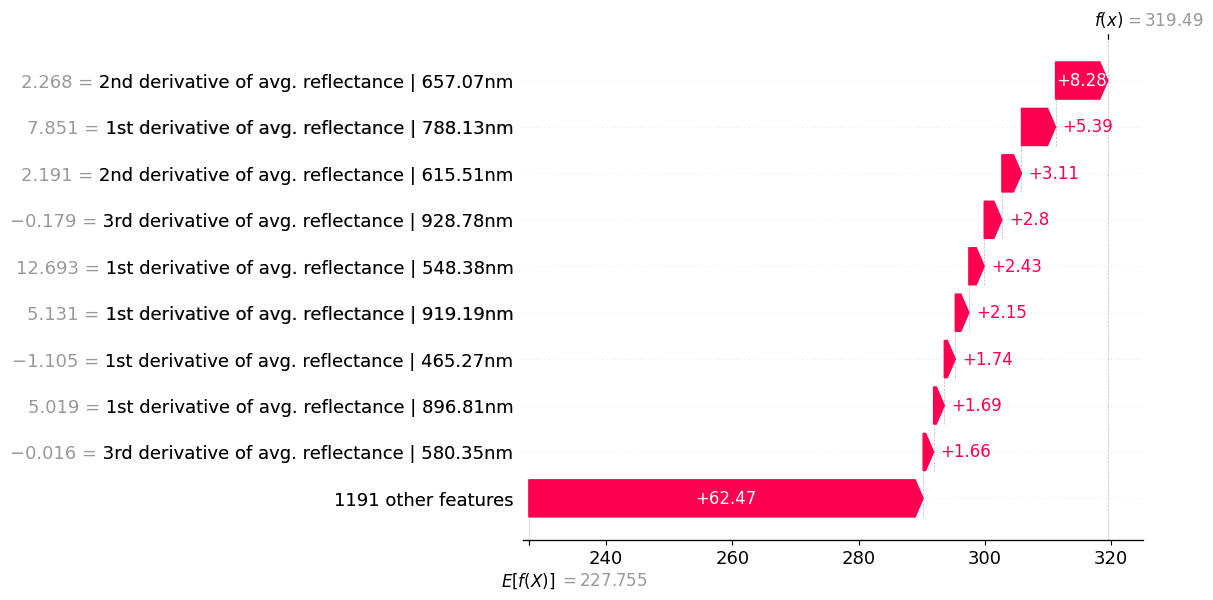

In [34]:
from meteors.visualize import waterfall

waterfall(explainer, explanation, target=1, observation_index=3, use_pyplot=True)

<Axes: xlabel='Instances'>

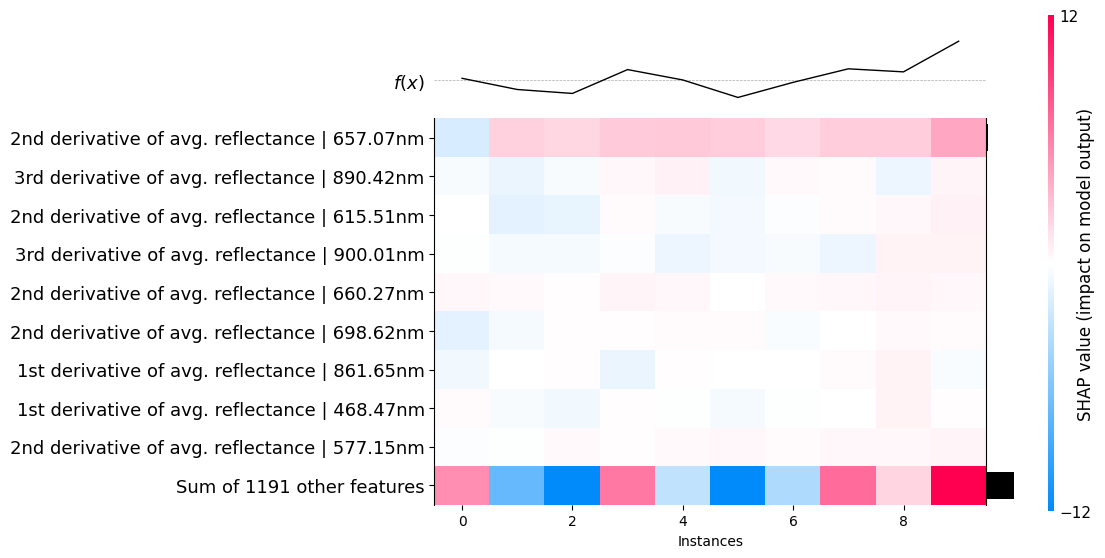

In [36]:
from meteors.visualize import heatmap

heatmap(explainer, explanation, target=2, use_pyplot=False)

### Beeswarm plot

The beeswarm plot is a visualization that shows the *global* behaviour of the model, by grouping all the obserwations together. It is similar to the waterfall plot, but instead of the stacking the SHAP values, it shows them as a scatter plot. Features shown are sorted by their absolute importance, so we can easily identify the most important features.

In the plot below, we can see that the features that contribute the most to the final prediction are the 2nd derivatives of bands with `615.51 nm` and `657.07 nm` wavelengths.

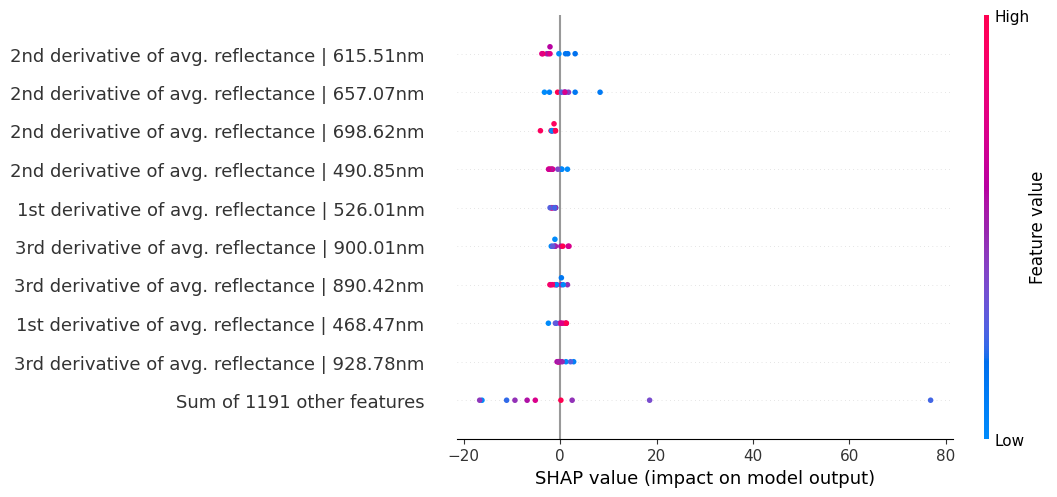

In [14]:
from meteors.visualize import beeswarm

beeswarm(explainer, explanation, target=1)
plt.show()

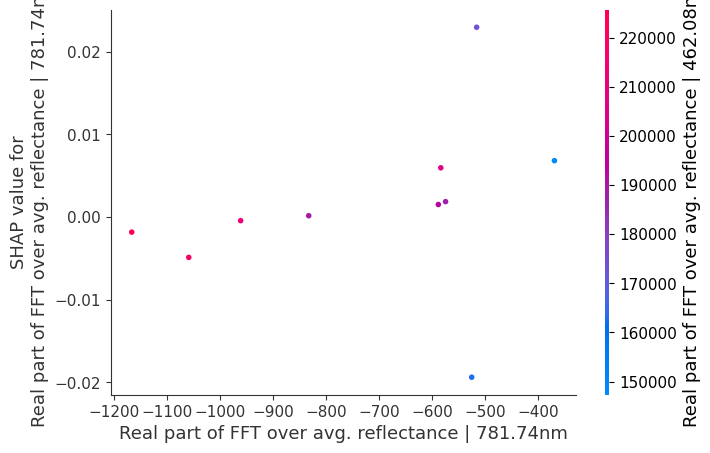

In [15]:
from meteors.visualize import dependence_plot

dependence_plot(100, explainer, explanation, target=1, use_pyplot=True)

this plot supports passing the feature index by hand, by default the feature taken to be displayed is the one with the highest correlation with the first one:

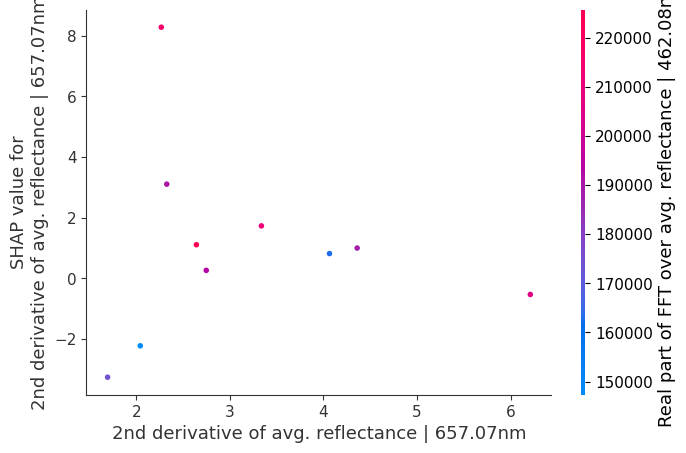

In [16]:
dependence_plot("2nd derivative of avg. reflectance | 657.07nm", explainer, explanation, target=1, use_pyplot=True)

Bar plot is another method of visualizing importance of certain features. It shows aggregated shaply values from all the data points.

As we can see below, similarly to the beeswarm plot, bar plot shows that the 2nd derivative of average reflectance of wavelength `657.07nm` is the most important one.

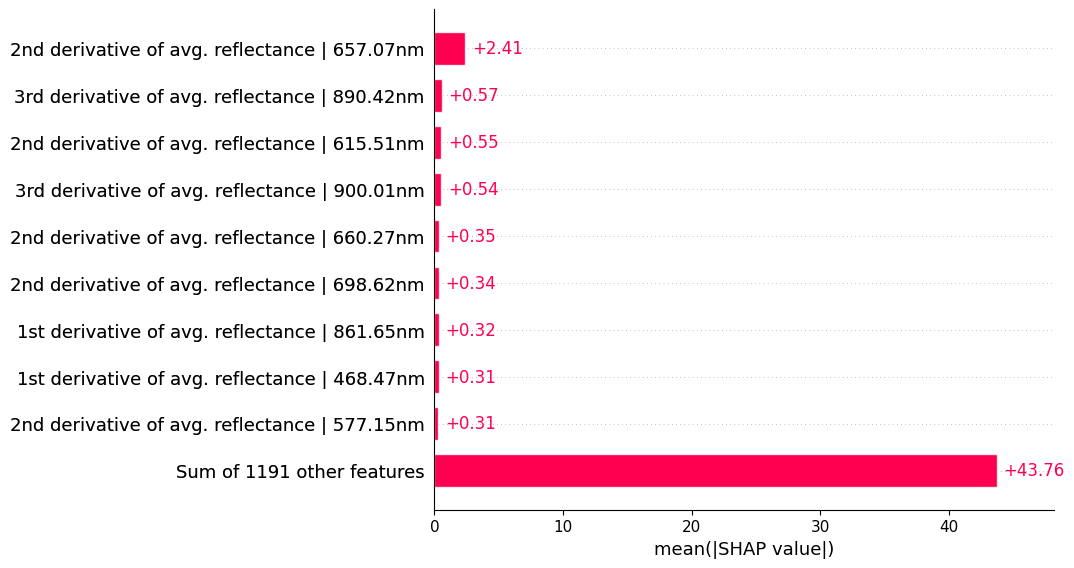

In [17]:
from meteors.visualize import bar

bar(explainer, explanation, target=2, use_pyplot=True)

### Wavelengths bar plot

Finally, we will utilize our domain knowledge to group similar features together. Since each feature is a transformed wavelength initial value, the `wavelengths_bar` plot groups the features by the wavelengths they represent. In this way, we can observe which bands are the most important for the model.

To create such plot, we first need to define which features map to which wavelengths. This should be done by passing a `wavelengths_mapping` dictionary as a parameter to the `wavelengths_bar` method. Keys of such dictionary are the wavelegths (a textual value, which will correspond to ticks of x-axis) and values are the indexes of the input dataframe. 

Similarly, we can provide a `transformations_mapping` dictionary, which contains information about the transformations applied to certain features and wavelengths. It should have the similar structure to the `wavelengths_mapping` dictionary, i.e. the keys are the feature names and values are the feature indexes of the input dataframe.

In [18]:
wavelengths_mapping = {str(wavelengths[i]): [150 * j + i for j in range(8)] for i in range(len(wavelengths))}

In [19]:
from eagleeyes import FEATURES

transformations_mapping = {FEATURES[i]: [j + i * 150 for j in range(len(wavelengths))] for i in range(len(FEATURES))}

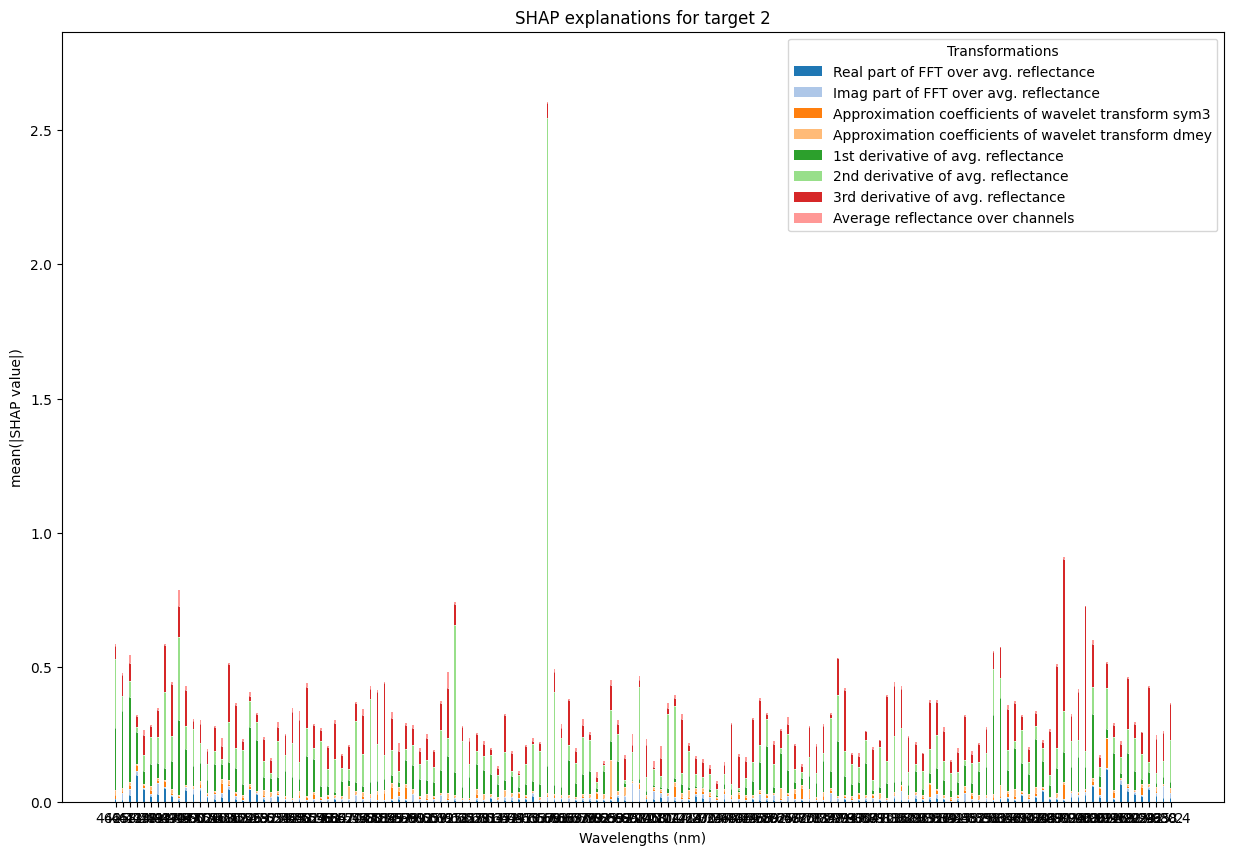

In [20]:
from meteors.visualize import wavelengths_bar

fig, ax = plt.subplots(figsize=(15, 10))
# ax.tick_params(axis='x', labelrotation=45)
wavelengths_bar(
    explainer,
    explanation,
    target=2,
    wavelengths_mapping=wavelengths_mapping,
    transformations_mapping=transformations_mapping,
    use_pyplot=True,
    ax=ax,
)

In the chart above, we can clearly see, that the single most important feature is the one of *657 nm* wavelength. 
Interestingly, only on a such small subset of features, we managed to discover one of the features that was found out to be important in our previous work [Red Teaming Models for Hyperspectral Image Analysis Using Explainable AI](https://arxiv.org/abs/2403.08017), in which we thoroughly analyzed the EagleEyes model. In the paper, we show that by selecting only 1% of the features used above, we can train a model which achieved only a 5% performance loss.

Now, we encourage you to conduct similar analysis of your models and data using the `meteors` package!